<a href="https://colab.research.google.com/github/HEM2058/sentinelhub_remote_sensing/blob/main/ndvi_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.6/245.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.4 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=2ecf79da5f3a9d5a1e3f8e12419fb9bc5e4fa2bc2765f54a34f8e0c90765c870
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [3]:
# This is script may only work with sentinelhub.__version__ >= '3.4.0'
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry

# Credentials
config = SHConfig()
config.sh_client_id = 'c26e1c4d-d7d7-4d63-b464-058267b7ded9'
config.sh_client_secret = 'PIsZreiBLs7LfPQRTPEdZfzq4bTFGHZA'

# Evalscript
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox= [
  83.895182,
  28.174928,
  84.007771,
  28.252377
], crs=CRS.WGS84)

# Create SentinelHub request with TIFF format and FLOAT32 sample type
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,

)


# Get data from the request
response = request.get_data()


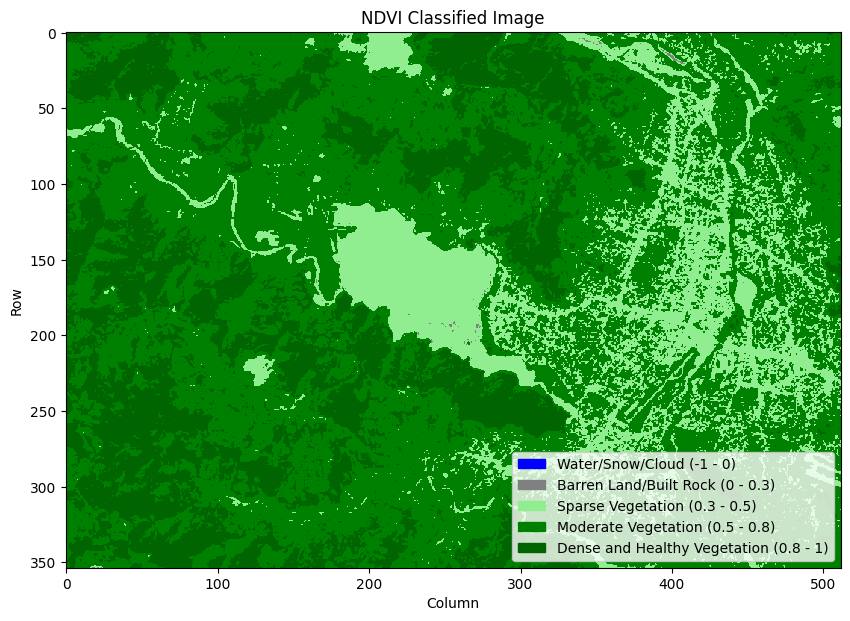

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

# Sample NDVI image data
ndvi_image = response[0]  # Assuming response[0] contains the NDVI data in matrix format

# Define the NDVI classification thresholds and corresponding labels
thresholds = [-1,0, 0.3, 0.5, 0.8, 1]
labels = ['Water/Snow/Cloud', 'Barren Land/Built Rock', 'Sparse Vegetation', 'Moderate Vegetation', 'Dense and Healthy Vegetation']

# Define colors for each class
colors = ['blue', 'grey', 'lightgreen', 'green', 'darkgreen']

# Create a colormap based on the defined colors
cmap = ListedColormap(colors)

# Normalize the NDVI values to the range [0, 1]
norm = Normalize(vmin=-1, vmax=1)

# Plot the NDVI image with colormap
plt.figure(figsize=(10, 8))
image = plt.imshow(ndvi_image, cmap=cmap, norm=norm)
plt.title('NDVI Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')

# Create legend with range for each label
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=f'{labels[i]} ({thresholds[i]} - {thresholds[i+1]})') for i in range(len(labels))]
plt.legend(handles=legend_handles, loc='lower right')

plt.show()
